In [1]:
import os
import sys
import pickle
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import models

from PIL import Image
import torchvision.utils as vutils

import random
from tqdm import tqdm
import matplotlib.pyplot as plt

def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3Q
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6
    


In [2]:
manual_seed(22)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 64

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((32,32)),
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data',train=True, download=False, transform=train_transforms)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True,drop_last=True)

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((32,32)),
])

val_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False,download=False ,transform=val_transforms)
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

print(len(val_dataset.data), len(val_loader))


10000 156


## VAE 학습
pretrain 한 layer를 넣어서

In [5]:
EPOCHS = 101
# LR = 1e-4
LR = 1e-5
LATENT_DIM = 2

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
encoder = models.Encoder(LATENT_DIM)
decoder = models.Decoder(LATENT_DIM)
model = models.VAEMLP(encoder, decoder)
# model.apply(weights_init)
print(model)

VAEMLP(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (z_mean): Linear(in_features=500, out_features=2, bias=True)
    (z_logvar): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=500, out_features=784, bias=True)
    )
  )
)


In [8]:
pretrained = torch.load('./check/clacheckpoint.pth')['model_state_dict']
init_dict = dict()
for key, val in pretrained.items():
    print(key)
    if key.startswith('layers.'):
        new_key = 'encoder.'+key
        init_dict[new_key] = val
if len(init_dict)==0:
    print(f"no weights to transfer.")
else:
    model.load_state_dict(init_dict, strict=False)
    print(f"initialize wieghts from pretrained classifier : {init_dict.keys()}")
    


layers.0.weight
layers.0.bias
fc2.weight
fc2.bias
initialize wieghts from pretrained classifier : dict_keys(['encoder.layers.0.weight', 'encoder.layers.0.bias'])


In [9]:
def kl_function(mean, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return KLD
MSE_loss = nn.MSELoss(reduction='sum')
KL_loss = kl_function

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

0 EPOCH - MSE : 77.00664, KL : 3.91492, ALL : 80.92156
1 EPOCH - MSE : 36.55555, KL : 5.49520, ALL : 42.05075
2 EPOCH - MSE : 33.02716, KL : 5.21576, ALL : 38.24292
3 EPOCH - MSE : 31.56703, KL : 5.03647, ALL : 36.60350
4 EPOCH - MSE : 30.71183, KL : 4.90303, ALL : 35.61486
5 EPOCH - MSE : 30.09431, KL : 4.81006, ALL : 34.90437
6 EPOCH - MSE : 29.62041, KL : 4.76523, ALL : 34.38564
7 EPOCH - MSE : 29.19689, KL : 4.73988, ALL : 33.93677
8 EPOCH - MSE : 28.82215, KL : 4.70842, ALL : 33.53058
9 EPOCH - MSE : 28.49631, KL : 4.70296, ALL : 33.19927
10 EPOCH - MSE : 28.21908, KL : 4.69369, ALL : 32.91277
11 EPOCH - MSE : 27.98467, KL : 4.67478, ALL : 32.65945
12 EPOCH - MSE : 27.78112, KL : 4.67713, ALL : 32.45825
13 EPOCH - MSE : 27.59918, KL : 4.66707, ALL : 32.26624
14 EPOCH - MSE : 27.44773, KL : 4.65194, ALL : 32.09967
15 EPOCH - MSE : 27.30357, KL : 4.64166, ALL : 31.94523
16 EPOCH - MSE : 27.17566, KL : 4.64360, ALL : 31.81926
17 EPOCH - MSE : 27.06256, KL : 4.63172, ALL : 31.69427
18

/tmp/ipykernel_353894/3288871758.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


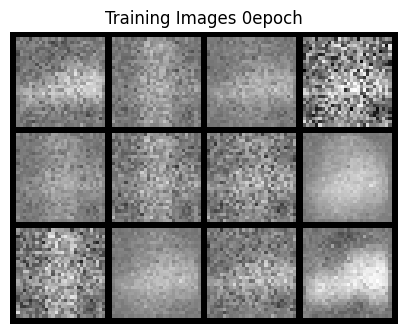

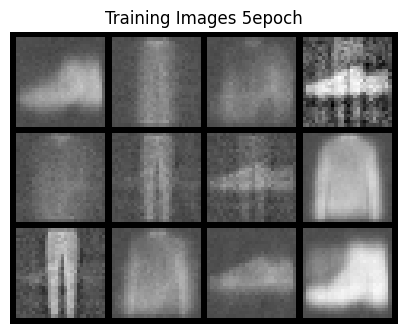

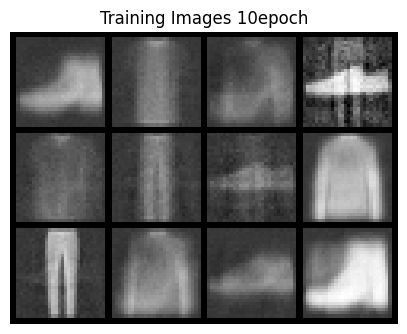

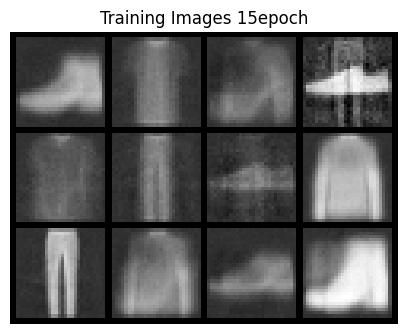

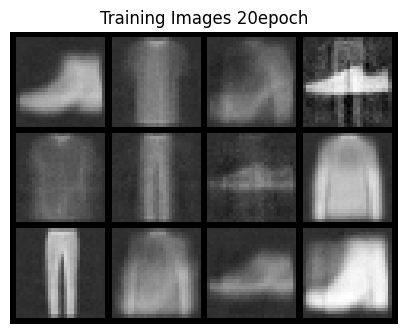

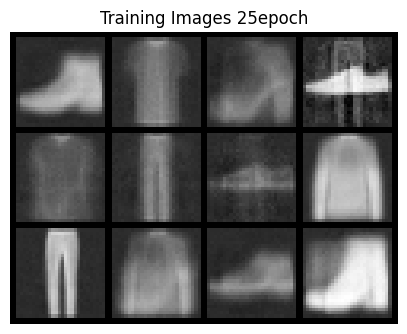

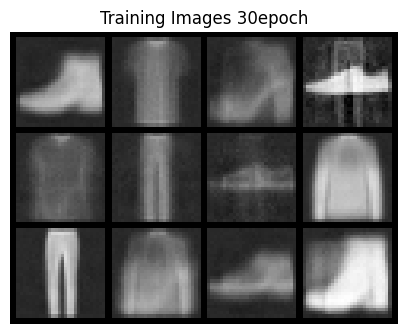

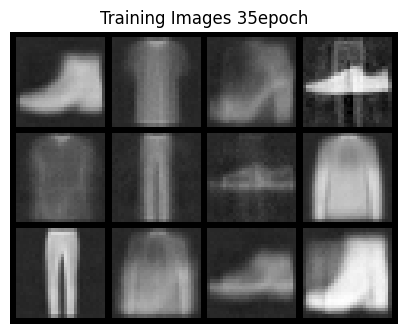

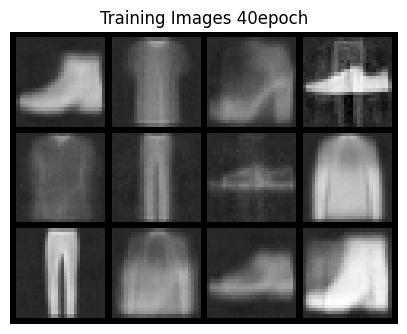

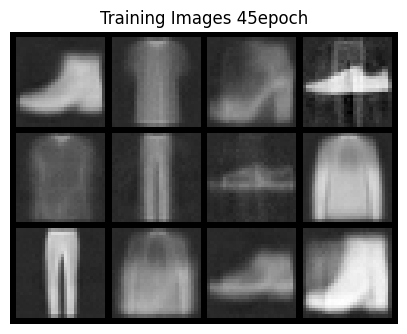

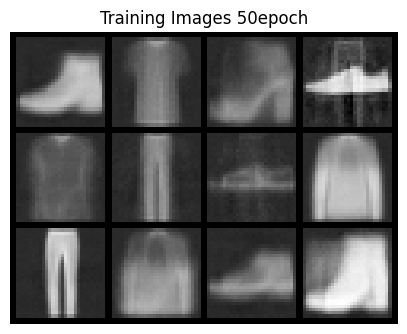

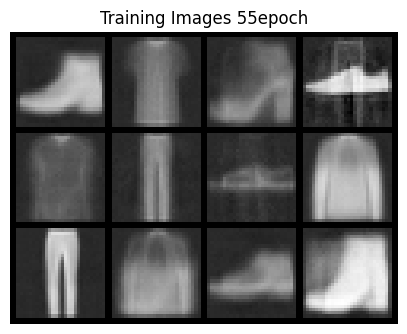

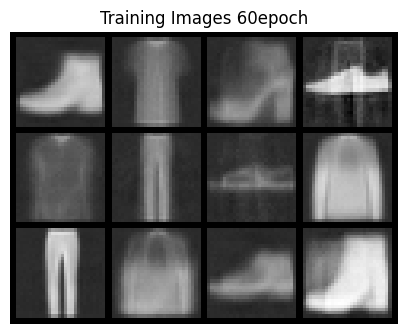

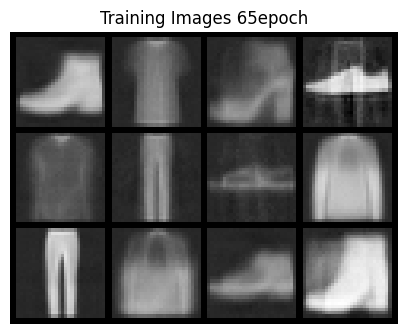

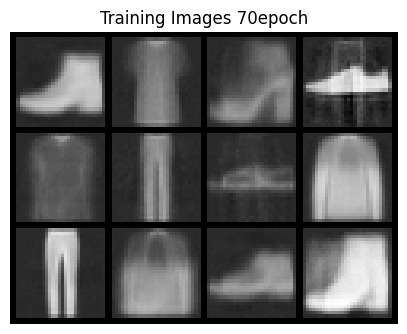

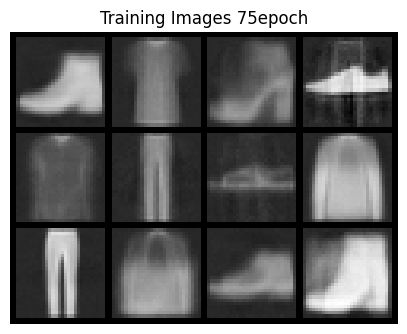

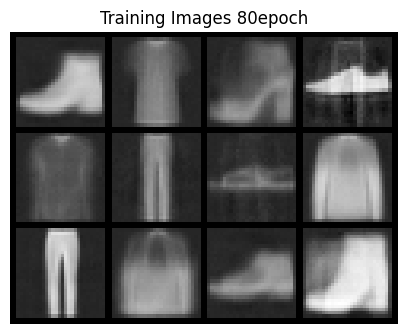

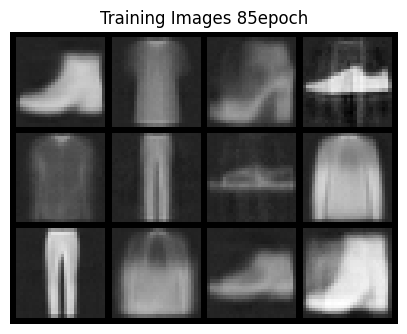

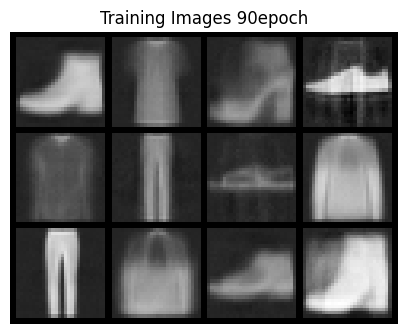

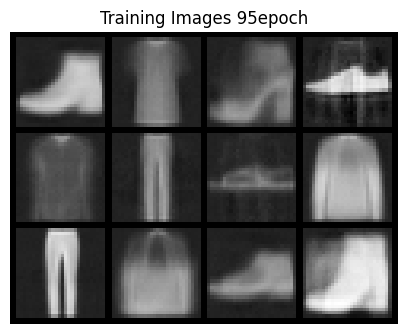

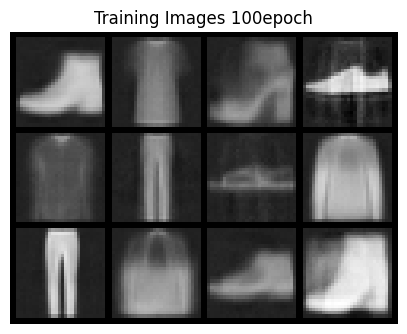

In [10]:
model.to(device)
generate_imgs = []
noise = torch.randn(batch_size, 2).to(device)
mse_list = []
kl_list = []
all_list = []

val_mse_list = []
val_kl_list = []
val_all_list = []
for epoch in range(EPOCHS):
    model.train()
    mse_loss = 0
    kl_loss = 0
    all_loss = 0
    for i, (imgs, _ ) in enumerate(train_loader):
        imgs = imgs.to(device)
        imgs = torch.flatten(imgs,1)
        optimizer.zero_grad()
        
        y , mean, log_var = model(imgs)
    
        mse = MSE_loss(y,imgs) 
        kl = KL_loss(mean,log_var)
    
        loss = mse+ kl
        loss.backward()
        optimizer.step()
        
        mse_loss += mse.item()    
        kl_loss += kl.item()    
        all_loss += loss.item() 
    
    mse_loss /=len(train_dataset)    
    kl_loss  /=len(train_dataset) 
    all_loss /=len(train_dataset) 
    
    print(f"{epoch} EPOCH - MSE : {mse_loss:.5f}, KL : {kl_loss:.5f}, ALL : {all_loss:.5f}")   
        
    mse_list.append(mse_loss)
    kl_list.append(kl_loss)
    all_list.append(all_loss)
    
    if (epoch % 5 == 0):
        with torch.no_grad():
            model.eval()
        
            # noise를 통과시킨 decoder의 이미지를를 저장해둡니다
            fake = model.decoder(noise[:12]).detach().cpu().view(12,1,28,28)
            # std = torch.exp(log_var / 2)
            # latent = mean + std * noise
            # fake = model.decoder(latent[:12]).detach().cpu().view(-1, 1, 28, 28)
            generate_imgs.append(vutils.make_grid(fake, nrow=4, padding=2,normalize=True))
            plt.figure(figsize=(5,5))
            plt.axis("off")
            plt.title(f"Training Images {epoch}epoch")
            plt.imshow(np.transpose(generate_imgs[-1],(1,2,0)))
            plt.savefig(f'./gen_imgs/pretrain_lowlr_{epoch}.png')

101


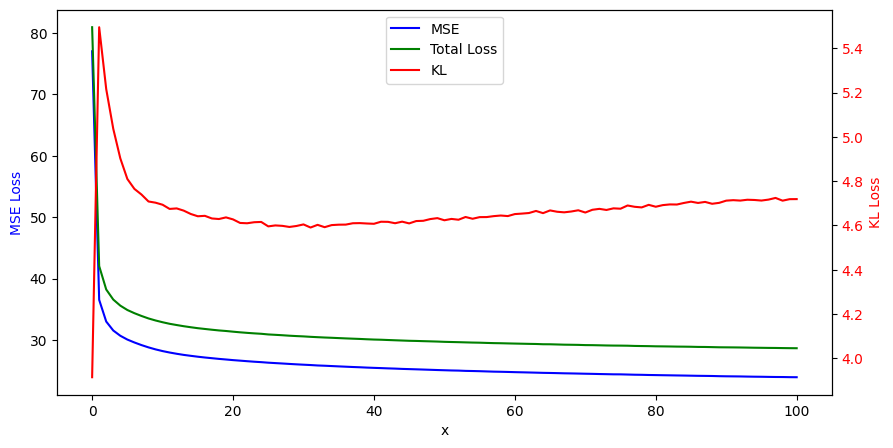

In [11]:
import matplotlib.pyplot as plt
print(len(mse_list))
fig = plt.figure(figsize=(10,5))
# plt.title(f"VAE Training Loss")
# plt.plot(mse_list,label="MSE")
# plt.plot(kl_list,label="KL")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")

ax1 = fig.add_subplot() ## 
color1 = 'b'
ax1.plot(mse_list, color=color1, label='MSE')
ax1.plot(all_list, color='g', label='Total Loss')
ax1.set_xlabel('x')
ax1.set_ylabel('MSE Loss', color=color1)

color2 = 'r'
ax2 = ax1.twinx()
ax2.plot(kl_list, color=color2, label = "KL")
ax2.set_ylabel('KL Loss', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.show()